In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import random as r
%matplotlib inline

In [4]:
# pip install nba_api
import nba_api as nba
import nba_api.stats.endpoints as ep

In [221]:
from nba_api.stats.static import teams

nba_teams = teams.get_teams()
# Select the dictionary for the Celtics, which contains their team ID
celtics = [team for team in nba_teams if team['abbreviation'] == 'BOS'][0]
celtics_id = celtics['id']

In [283]:
from nba_api.stats.endpoints import leaguegamefinder

# Query for games where the Celtics were playing
gamefinder = leaguegamefinder.LeagueGameFinder(league_id_nullable='00')
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]
games = games.dropna(how='any',axis=0)
games = games[games.SEASON_ID.str[-4:] != '2022']
games = games[games.SEASON_ID.str[-4:] != '2021']
games.head(10)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
3270,42020,1610612749,MIL,Milwaukee Bucks,0042000406,2021-07-20,MIL vs. PHX,W,240,105,...,0.862,11,42,53,20,10,6,18,17,7.0
3271,42020,1610612756,PHX,Phoenix Suns,0042000406,2021-07-20,PHX @ MIL,L,239,98,...,0.842,6,31,37,14,11,4,14,21,-7.0
3272,42020,1610612756,PHX,Phoenix Suns,0042000405,2021-07-17,PHX vs. MIL,L,241,119,...,0.909,8,27,35,23,9,5,8,20,-4.0
3273,42020,1610612749,MIL,Milwaukee Bucks,0042000405,2021-07-17,MIL @ PHX,W,240,123,...,0.529,11,26,37,26,7,1,11,17,4.0
3274,42020,1610612749,MIL,Milwaukee Bucks,0042000404,2021-07-14,MIL vs. PHX,W,240,109,...,0.828,17,31,48,22,11,3,5,18,6.0
3275,42020,1610612756,PHX,Phoenix Suns,0042000404,2021-07-14,PHX @ MIL,L,240,103,...,0.842,5,35,40,18,3,9,17,24,-6.0
3276,42020,1610612749,MIL,Milwaukee Bucks,0042000403,2021-07-11,MIL vs. PHX,W,240,120,...,0.769,13,34,47,28,8,2,9,18,20.0
3277,42020,1610612756,PHX,Phoenix Suns,0042000403,2021-07-11,PHX @ MIL,L,239,100,...,0.688,6,30,36,21,3,3,14,24,-20.0
3278,42020,1610612756,PHX,Phoenix Suns,0042000402,2021-07-08,PHX vs. MIL,W,240,118,...,0.857,11,32,43,26,7,2,12,19,10.0
3279,42020,1610612749,MIL,Milwaukee Bucks,0042000402,2021-07-08,MIL @ PHX,L,240,108,...,0.652,18,28,46,21,8,7,9,17,-10.0


In [284]:
outcomes = games[games.columns[7]]
gamestats = games[games.columns[10:27]]
outcomes.head()

3270    W
3271    L
3272    L
3273    W
3274    W
Name: WL, dtype: object

In [285]:
gamestats.head()

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF
3270,37,82,0.451,6,27,0.222,25,29,0.862,11,42,53,20,10,6,18,17
3271,38,86,0.442,6,25,0.240,16,19,0.842,6,31,37,14,11,4,14,21
3272,48,87,0.552,13,19,0.684,10,11,0.909,8,27,35,23,9,5,8,20
3273,50,87,0.575,14,28,0.500,9,17,0.529,11,26,37,26,7,1,11,17
3274,39,97,0.402,7,29,0.241,24,29,0.828,17,31,48,22,11,3,5,18


In [286]:
from sklearn.model_selection import train_test_split

In [287]:
X = gamestats.to_numpy()
y = outcomes.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [288]:
# LinearSVC classification (Accuracy of 68.46%)
from sklearn.svm import LinearSVC
lclf = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
lclf.fit(X_train, y_train)
print(lclf.score(X_test,y_test))

# KNN model attempt (Accuracy of 69.55%, with k=10)
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

# SVC prediction model attempt (Accuracy of 72.52%, gamma set to 'scale' )
from sklearn.svm import SVC
from sklearn import svm
clf = SVC(gamma='scale',probability=True)
clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))

#BaggingSVC Ensemble classification (Accuracy of 72.49%)
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
advclf = BaggingClassifier(base_estimator=SVC(gamma='scale'), n_estimators=10, random_state=0)
advclf.fit(X_train, y_train)
print(advclf.score(X_test,y_test))

# Random Forest Classification model (Accuracy of 72.17%)
from sklearn.ensemble import RandomForestClassifier
routcomes = RandomForestClassifier(max_depth=8, random_state=0, n_estimators=300)
routcomes.fit(X_train, y_train)
print(routcomes.score(X_test,y_test))

# XGBoost Classification (Accuracy of 68.61%)
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score
# xgbModel = XGBClassifier()
# xgbModel.fit(X_train, y_train)
# xgbPredictions = xgbModel.predict(X_test)
# xgbAccuracy = accuracy_score(y_test, xgbPredictions)

c:\Users\parag\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8164983164983165
0.787317620650954
0.8509165731387953
0.8514777403666293
0.8009726898615788


In [292]:
from nba_api.stats.static import teams
from nba_api.stats.static import players

nba_teams = teams.get_teams()
nba_players = players.get_players()


team = [team for team in nba_teams
          if team['full_name'] == 'Los Angeles Lakers'][0]

In [293]:
team_games = leaguegamefinder.LeagueGameFinder(team_id_nullable=team['id'],season_nullable='2021-22'or'2022-23')
team_games = team_games.get_data_frames()[0]
team_games = team_games.dropna(how='any',axis=0)
team_games.tail()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
83,12021,1610612747,LAL,Los Angeles Lakers,0012100047,2021-10-12,LAL vs. GSW,L,239,99,...,0.773,6,46,52,22,9,6,20,22,-12.0
84,12021,1610612747,LAL,Los Angeles Lakers,0012100038,2021-10-10,LAL vs. PHX,L,241,94,...,0.682,7,29,36,23,12,5,23,21,-29.0
85,12021,1610612747,LAL,Los Angeles Lakers,0012100031,2021-10-08,LAL @ GSW,L,242,114,...,0.719,14,42,56,22,8,3,27,22,-7.0
86,12021,1610612747,LAL,Los Angeles Lakers,0012100020,2021-10-06,LAL @ PHX,L,241,105,...,0.789,4,36,40,24,10,4,17,21,-12.0
87,12021,1610612747,LAL,Los Angeles Lakers,0012100001,2021-10-03,LAL vs. BKN,L,241,97,...,0.688,13,28,41,17,9,6,16,30,-26.0


In [294]:
team_games.isnull().values.any()

False

In [295]:
team_outcomes = team_games[games.columns[7]]
team_gamestats = team_games[games.columns[10:27]]
team_gamestats_mean = pd.DataFrame(team_gamestats.mean(axis=0)).transpose()

In [296]:
team_gamestats_mean.head()

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF
0,41.329545,88.727273,0.465739,11.954545,34.465909,0.346102,16.897727,23.125,0.73367,9.5,34.693182,44.193182,23.875,7.727273,5.181818,14.284091,20.386364


In [297]:
team_gamestats_mean_X = pd.DataFrame(np.repeat(team_gamestats_mean.values, len(team_games), axis=0))
team_gamestats_mean_X.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
83,41.329545,88.727273,0.465739,11.954545,34.465909,0.346102,16.897727,23.125,0.73367,9.5,34.693182,44.193182,23.875,7.727273,5.181818,14.284091,20.386364
84,41.329545,88.727273,0.465739,11.954545,34.465909,0.346102,16.897727,23.125,0.73367,9.5,34.693182,44.193182,23.875,7.727273,5.181818,14.284091,20.386364
85,41.329545,88.727273,0.465739,11.954545,34.465909,0.346102,16.897727,23.125,0.73367,9.5,34.693182,44.193182,23.875,7.727273,5.181818,14.284091,20.386364
86,41.329545,88.727273,0.465739,11.954545,34.465909,0.346102,16.897727,23.125,0.73367,9.5,34.693182,44.193182,23.875,7.727273,5.181818,14.284091,20.386364
87,41.329545,88.727273,0.465739,11.954545,34.465909,0.346102,16.897727,23.125,0.73367,9.5,34.693182,44.193182,23.875,7.727273,5.181818,14.284091,20.386364


In [298]:
print(len(team_gamestats_mean_X))

88


In [299]:
X_test = team_gamestats_mean_X.to_numpy()
y_test = team_outcomes.to_numpy()
print(np.shape(X_test))
print(np.shape(y_test))
print(lclf.score(X_test,y_test))
print(knn.score(X_test, y_test))
print(clf.score(X_test,y_test))
print(advclf.score(X_test,y_test))
print(routcomes.score(X_test,y_test))

(88, 17)
(88,)
0.625
0.375
0.625
0.625
0.375


In [300]:
def model_scores():
    scores = []
    for team in nba_teams:
        tmp_scores = []
        team_games = leaguegamefinder.LeagueGameFinder(team_id_nullable=team['id'],season_nullable='2021-22'or'2022-23')
        team_games = team_games.get_data_frames()[0]
        team_games = team_games.dropna(how='any',axis=0)

        team_outcomes = team_games[games.columns[7]]
        team_gamestats = team_games[games.columns[10:27]]
        team_gamestats_mean = pd.DataFrame(team_gamestats.mean(axis=0)).transpose()
        team_gamestats_mean_X = pd.DataFrame(np.repeat(team_gamestats_mean.values, len(team_games), axis=0))

        X_test = team_gamestats_mean_X.to_numpy()
        y_test = team_outcomes.to_numpy()
        tmp_scores.append(lclf.score(X_test,y_test))
        tmp_scores.append(knn.score(X_test, y_test))
        tmp_scores.append(clf.score(X_test,y_test))
        tmp_scores.append(advclf.score(X_test,y_test))
        tmp_scores.append(routcomes.score(X_test,y_test))

        scores.append(tmp_scores)
    return scores

In [301]:
scores = model_scores()

In [302]:
team_names = []
for team in nba_teams:
	team_names.append(team['full_name'])

In [303]:
scores_df = pd.DataFrame(scores,index=team_names,columns=['LinearSVC','KNN','SVC Predict','BaggingSVC','Random Forest'])

In [304]:
scores_df.style.background_gradient(cmap ='YlOrRd')\
        .set_properties(**{'font-size': '20px'})

# cmap ='viridis'

,LinearSVC,KNN,SVC Predict,BaggingSVC,Random Forest
Atlanta Hawks,0.516129,0.516129,0.516129,0.516129,0.516129
Boston Celtics,0.609091,0.390909,0.609091,0.609091,0.609091
Cleveland Cavaliers,0.483146,0.516854,0.516854,0.516854,0.516854
New Orleans Pelicans,0.563830,0.436170,0.436170,0.436170,0.563830
Chicago Bulls,0.439560,0.439560,0.560440,0.560440,0.560440
Dallas Mavericks,0.375000,0.375000,0.625000,0.625000,0.375000
Denver Nuggets,0.543478,0.543478,0.543478,0.543478,0.543478
Golden State Warriors,0.678899,0.678899,0.678899,0.678899,0.678899
Houston Rockets,0.755814,0.755814,0.755814,0.755814,0.755814
Los Angeles Clippers,0.511364,0.488636,0.488636,0.488636,0.488636


In [346]:
playername = 'Nikola Jokic'
jokic = [player for player in nba_players
        if player['full_name'] == playername][0]
print(jokic)

playername = 'Jamal Murray'
murray = [player for player in nba_players
        if player['full_name'] == playername][0]
print(murray)

teamname = 'Denver Nuggets'
team = [team for team in nba_teams
          if team['full_name'] == teamname][0]
print(team)

{'id': 203999, 'full_name': 'Nikola Jokic', 'first_name': 'Nikola', 'last_name': 'Jokic', 'is_active': True}
{'id': 1627750, 'full_name': 'Jamal Murray', 'first_name': 'Jamal', 'last_name': 'Murray', 'is_active': True}
{'id': 1610612743, 'full_name': 'Denver Nuggets', 'abbreviation': 'DEN', 'nickname': 'Nuggets', 'city': 'Denver', 'state': 'Colorado', 'year_founded': 1976}


In [374]:
shot_data = ep.shotchartdetail.ShotChartDetail(player_id = jokic['id'], team_id = team['id'], season_nullable = '2021-22').get_data_frames()[0]

In [375]:
shot_data.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022100012,7,203999,Nikola Jokic,1610612743,Denver Nuggets,1,11,45,...,Center(C),16-24 ft.,18,43,179,1,1,20211020,PHX,DEN
1,Shot Chart Detail,0022100012,42,203999,Nikola Jokic,1610612743,Denver Nuggets,1,8,8,...,Center(C),Less Than 8 ft.,0,-5,1,1,1,20211020,PHX,DEN
2,Shot Chart Detail,0022100012,67,203999,Nikola Jokic,1610612743,Denver Nuggets,1,5,35,...,Center(C),Less Than 8 ft.,7,-61,38,1,1,20211020,PHX,DEN
3,Shot Chart Detail,0022100012,73,203999,Nikola Jokic,1610612743,Denver Nuggets,1,5,9,...,Center(C),Less Than 8 ft.,6,7,62,1,1,20211020,PHX,DEN
4,Shot Chart Detail,0022100012,124,203999,Nikola Jokic,1610612743,Denver Nuggets,1,2,13,...,Center(C),Less Than 8 ft.,0,0,0,1,1,20211020,PHX,DEN


In [377]:
# Helper function to draw court
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

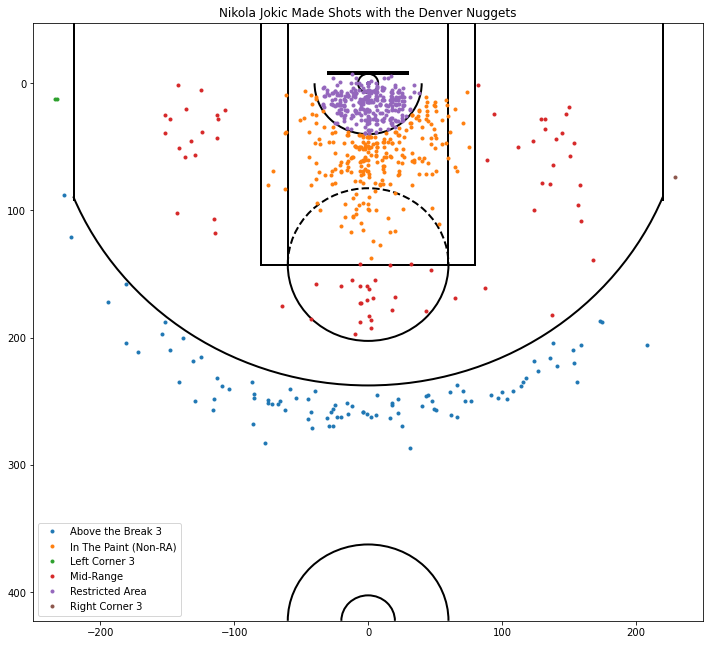

In [378]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,11))
groups = shot_data.groupby('SHOT_ZONE_BASIC')
for name, group in groups:
    ax.plot(group['LOC_X'], group['LOC_Y'], marker='.', linestyle='', label=name)
    ax.set_title(player['full_name'] + ' Made Shots with the ' + team['full_name'])
# ax.set(xlim=(, xmax), ylim=(ymin, ymax))

plt.legend()
# draw_court(outer_lines=True)
# # Descending values along the axis from left to right
# plt.xlim(300, -300)


draw_court() 
# Adjust plot limits to just fit in half court
plt.xlim(-250, 250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

plt.show()

In [353]:
data = ep.leaguedashteamshotlocations.LeagueDashTeamShotLocations(season = '2022-23').get_data_frames()[0]

In [354]:
data

SHOT_CATEGORY                                     Restricted Area              \
columns           TEAM_ID               TEAM_NAME             FGM  FGA FG_PCT   
0              1610612737           Atlanta Hawks             207  316  0.655   
1              1610612738          Boston Celtics             182  270  0.674   
2              1610612751           Brooklyn Nets             189  277  0.682   
3              1610612766       Charlotte Hornets             245  397  0.617   
4              1610612741           Chicago Bulls             219  376  0.582   
5              1610612739     Cleveland Cavaliers             191  281  0.680   
6              1610612742        Dallas Mavericks             186  285  0.653   
7              1610612743          Denver Nuggets             214  321  0.667   
8              1610612765         Detroit Pistons             186  320  0.581   
9              1610612744   Golden State Warriors             162  242  0.669   
10             1610612745         Houston Rockets             214  354  0.605   
11             1610612754          Indiana Pacers             197  304  0.648   
12             1610612746             LA Clippers             193  269  0.717   
13             1610612747      Los Angeles Lakers             245  369  0.664   
14             1610612763       Memphis Grizzlies             210  341  0.616   
15             1610612748              Miami Heat             167  264  0.633   
16             1610612749         Milwaukee Bucks             208  302  0.689   
17             1610612750  Minnesota Timberwolves             247  365  0.677   
18             1610612740    New Orleans Pelicans             228  368  0.620   
19             1610612752         New York Knicks             211  332  0.636   
20             1610612760   Oklahoma City Thunder             223  366  0.609   
21             1610612753           Orlando Magic             232  333  0.697   
22             1610612755      Philadelphia 76ers             151  254  0.594   
23             1610612756            Phoenix Suns             181  266  0.680   
24             1610612757  Portland Trail Blazers             212  330  0.642   
25             1610612758        Sacramento Kings             152  211  0.720   
26             1610612759       San Antonio Spurs             206  318  0.648   
27             1610612761         Toronto Raptors             203  316  0.642   
28             1610612762               Utah Jazz             233  356  0.654   
29             1610612764      Washington Wizards             194  271  0.716   

SHOT_CATEGORY In The Paint (Non-RA)             Mid-Range       ...  \
columns                         FGM  FGA FG_PCT       FGM  FGA  ...   
0                                90  226  0.398        87  191  ...   
1                                55  142  0.387        44   82  ...   
2                                79  184  0.429        77  165  ...   
3                                59  185  0.319        51  135  ...   
4                                55  150  0.367       109  218  ...   
5                                88  210  0.419        38  103  ...   
6                                47  101  0.465        26   70  ...   
7                                71  179  0.397        52  118  ...   
8                                71  200  0.355        64  142  ...   
9                                84  170  0.494        63  130  ...   
10                               76  202  0.376        23   84  ...   
11                               54  155  0.348        40  101  ...   
12                               78  175  0.446        72  160  ...   
13                               59  162  0.364        36  111  ...   
14                              122  272  0.449        31   85  ...   
15                               74  166  0.446        50  126  ...   
16                               46  134  0.343        49  140  ...   
17                               72  175  0.411        55 